In [1]:
import os
import numpy as np
import pandas as pd
import ot

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import compute

In [2]:
# Set Seaborn style for report-quality plots
sns.set_theme(
    style="whitegrid",  # White background with gridlines
    palette="muted",    # Muted color palette for better readability
    rc={
        "axes.titlesize": 16,       # Larger title size
        "axes.labelsize": 14,       # Larger label size
        "xtick.labelsize": 12,      # Tick label size
        "ytick.labelsize": 12,      # Tick label size
        "axes.linewidth": 1,        # Thickness of axis lines
        "grid.linewidth": 0.8,      # Thickness of grid lines
        "grid.color": "lightgray",  # Gridline color
        "legend.fontsize": 12,      # Legend font size
        "figure.figsize": (12, 8),  # Default figure size
        "font.family": "sans-serif", # Font style
        "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],  # Fallback fonts
    }
)

In [3]:
data_folder = 'stocks/'

stock_data = {}
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        filename = file.split('.')[:-1]
        filename = '.'.join(filename)
        symbol = filename.split('_')[0]
        file_path = os.path.join(data_folder, file)
        stock_data[symbol] = pd.read_csv(file_path, index_col=0, parse_dates=True)

print(f"Loaded data for {len(stock_data)} symbols.")

Loaded data for 10 symbols.


In [4]:
for stock, df in stock_data.items():
    print(f"Stock {stock} has data from {df.index.min()} to {df.index.max()}")

Stock BA has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock PG has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock AMZN has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock NEE has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock IBM has data from 1999-11-01 00:00:00 to 2024-12-13 00:00:00
Stock JPM has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock GOOGL has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock DUK has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock AAPL has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00
Stock JNJ has data from 2014-12-15 00:00:00 to 2024-12-13 00:00:00


In [5]:
def filter_by_year(data_dict, start_year, end_year):
    filtered_dict = {}
    for symbol, df in data_dict.items():
        mask = (df.index.year >= start_year) & (df.index.year <= end_year)
        filtered_dict[symbol] = df.loc[mask].copy()
    return filtered_dict


start_year = 2014
end_year = 2024

data = filter_by_year(stock_data, start_year, end_year)

In [6]:
# Perform the following standardization (z-score)
all_daily = []
all_weekly = []
all_monthly = []

for symbol, df in data.items():
    # Drop NaNs to avoid messing up the scaling
    daily_nonan = df['daily_return'].dropna()
    weekly_nonan = df['weekly_return'].dropna()
    monthly_nonan = df['monthly_return'].dropna()
    
    all_daily.append(daily_nonan)
    all_weekly.append(weekly_nonan)
    all_monthly.append(monthly_nonan)
    
all_daily = pd.concat(all_daily, axis=0).values.reshape(-1, 1)
all_weekly = pd.concat(all_weekly, axis=0).values.reshape(-1, 1)
all_monthly = pd.concat(all_monthly, axis=0).values.reshape(-1, 1)

# Fit scalers
scaler_daily = StandardScaler().fit(all_daily)
scaler_weekly = StandardScaler().fit(all_weekly)
scaler_monthly = StandardScaler().fit(all_monthly)

In [7]:
for symbol, df in data.items():
    df['daily_return_norm'] = scaler_daily.transform(df[['daily_return']].to_numpy())
    df['weekly_return_norm'] = scaler_weekly.transform(df[['weekly_return']].to_numpy())
    df['monthly_return_norm'] = scaler_monthly.transform(df[['monthly_return']].to_numpy())

# EXPLORATORY DATA ANALYSIS

In [8]:
def subset_symbols(symbols):
    subset_data = {symbol: df for symbol, df in data.items() if symbol in symbols}
    return subset_data

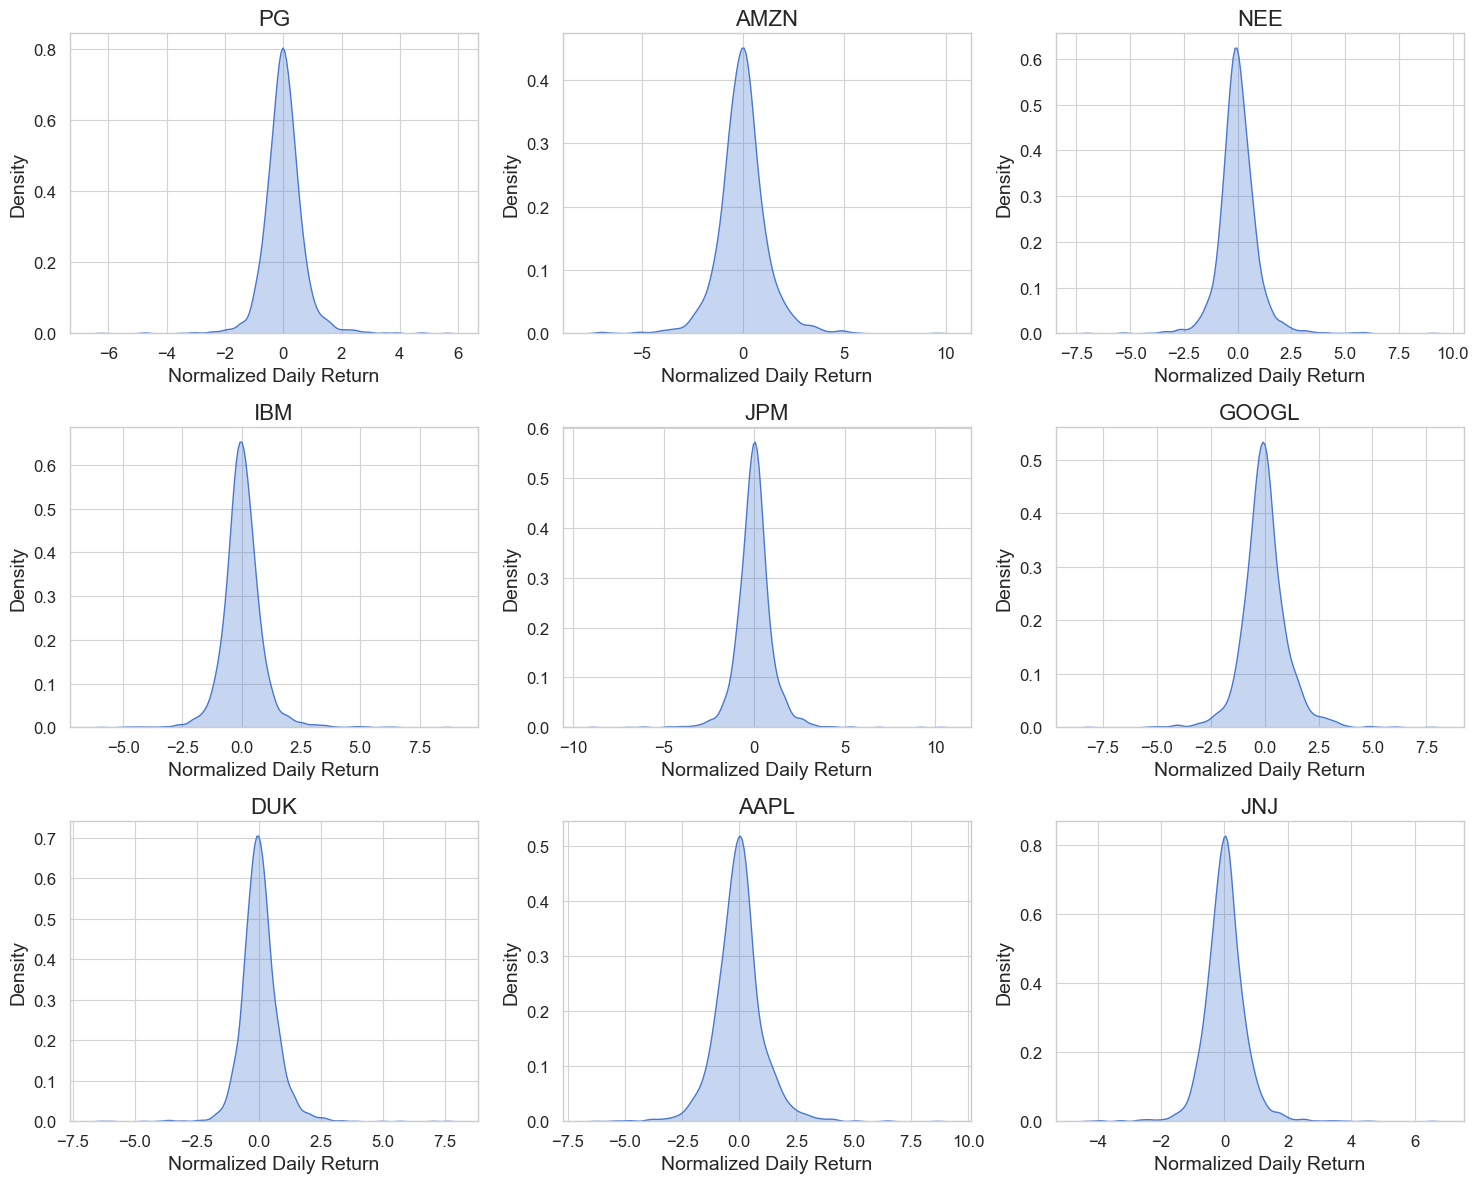

In [9]:
subset_data = subset_symbols(['AAPL', 'AMZN', 'GOOGL', 'DUK', 'JNJ', 'JPM', 'NEE', 'PG', 'IBM'])

num_plots = len(subset_data)
nrows = (num_plots + 2) // 3
ncols = 3  # Fixed to 3 columns for aesthetics

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Plot each symbol
for i, (symbol, df) in enumerate(subset_data.items()):
    sns.kdeplot(df['daily_return_norm'], ax=axes[i], fill=True, alpha=0.3)
    axes[i].set_title(symbol)
    axes[i].set_xlabel('Normalized Daily Return')
    axes[i].set_ylabel('Density')

# Turn off unused subplots
for i in range(len(subset_data), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
for symbol, df in subset_data.items():
    print(f"{symbol} has maximum daily price return of {df['daily_return_norm'].max()}")

PG has maximum daily price return of 5.621678588235487
AMZN has maximum daily price return of 9.585929802607577
NEE has maximum daily price return of 9.088497100370843
IBM has maximum daily price return of 8.649143044679953
JPM has maximum daily price return of 10.31911898394764
GOOGL has maximum daily price return of 7.72438696694248
DUK has maximum daily price return of 7.625532835860686
AAPL has maximum daily price return of 8.65991425445791
JNJ has maximum daily price return of 6.548949531100369


In [11]:
for symbol, df in subset_data.items():
    print(f"{symbol} has maximum weekly price return of {df['weekly_return_norm'].max()}")

PG has maximum weekly price return of 5.092695040072329
AMZN has maximum weekly price return of 6.684760389230897
NEE has maximum weekly price return of 8.41434729963677
IBM has maximum weekly price return of 6.8032364203228415
JPM has maximum weekly price return of 7.8545837751428795
GOOGL has maximum weekly price return of 4.793391443516083
DUK has maximum weekly price return of 6.643434804276842
AAPL has maximum weekly price return of 5.5672975490260415
JNJ has maximum weekly price return of 4.010886189936891


In [12]:
for symbol, df in subset_data.items():
    print(f"{symbol} has maximum monthly price return of {df['monthly_return_norm'].max()}")

PG has maximum monthly price return of 1.490674663362115
AMZN has maximum monthly price return of 4.30840646152837
NEE has maximum monthly price return of 2.8430629027205674
IBM has maximum monthly price return of 4.434998894613408
JPM has maximum monthly price return of 4.760988500835279
GOOGL has maximum monthly price return of 3.1297870196855344
DUK has maximum monthly price return of 2.6871958697933462
AAPL has maximum monthly price return of 3.3466555661872377
JNJ has maximum monthly price return of 1.8518032867587275


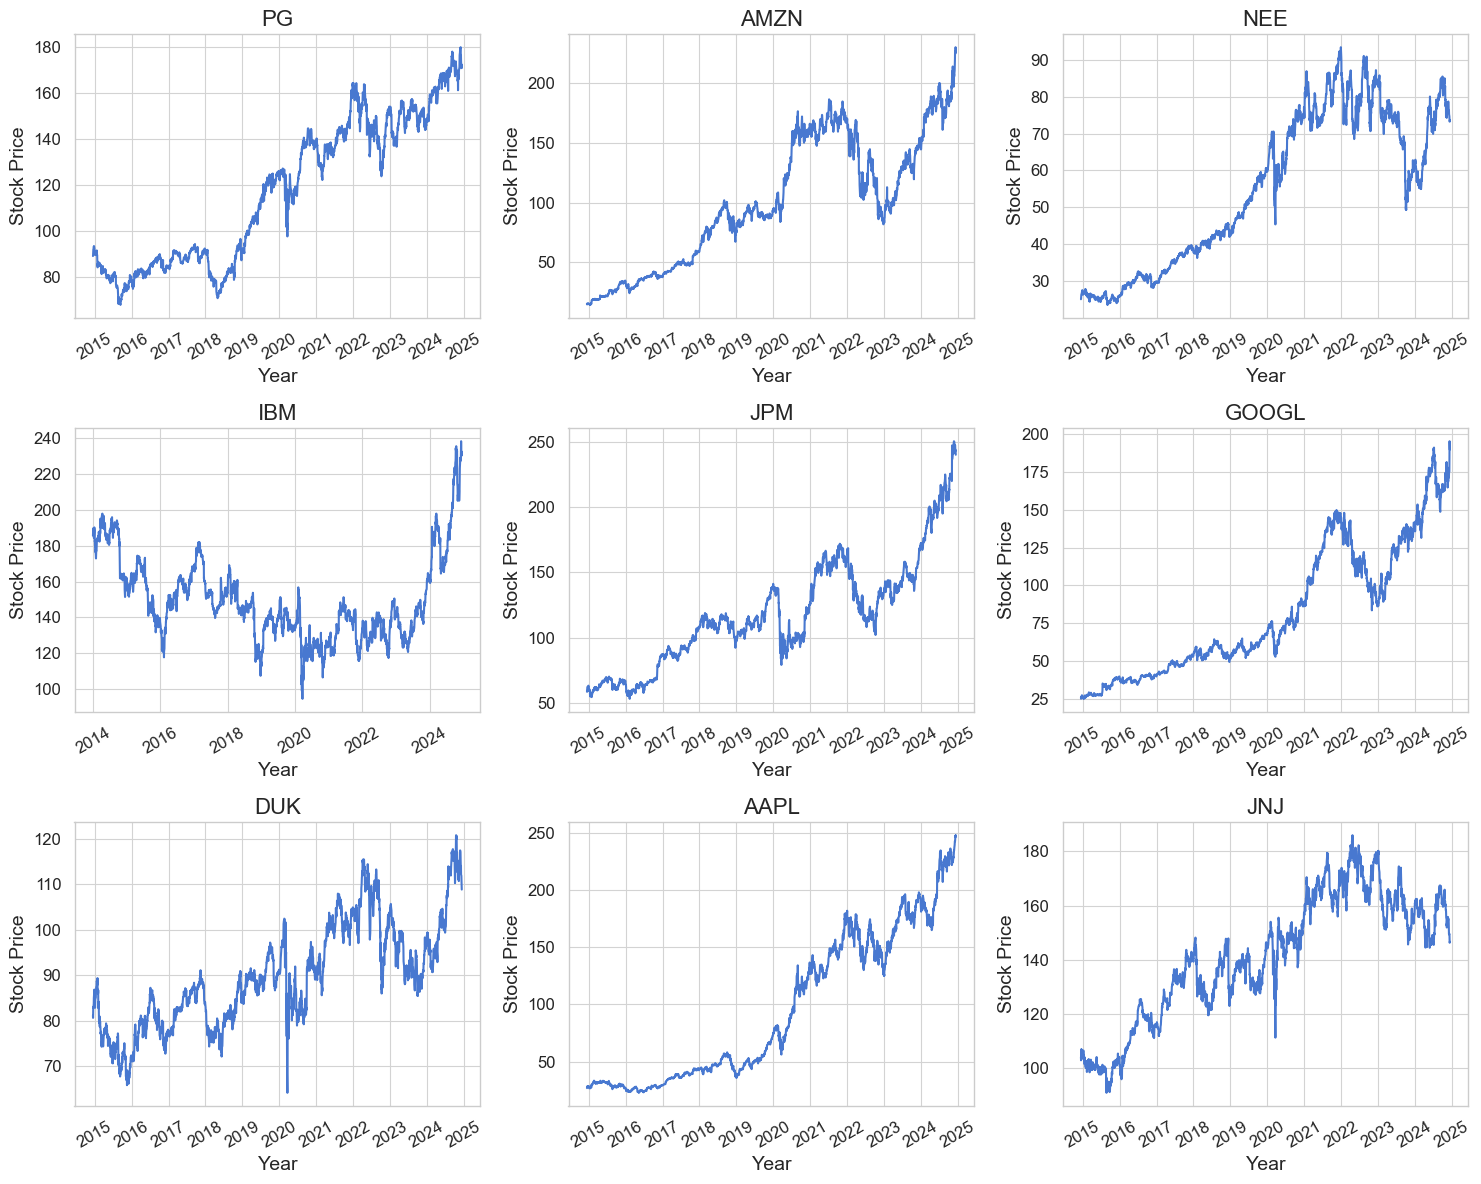

In [13]:
subset_data = subset_symbols(['AAPL', 'AMZN', 'GOOGL', 'DUK', 'JNJ', 'JPM', 'NEE', 'PG', 'IBM'])

num_plots = len(subset_data)
nrows = (num_plots + 2) // 3
ncols = 3  # Fixed to 3 columns for aesthetics

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Plot each symbol
for i, (symbol, df) in enumerate(subset_data.items()):
    sns.lineplot(df['close'], ax=axes[i])
    axes[i].set_title(symbol)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Stock Price')
    axes[i].tick_params(axis='x', rotation=30)

# Turn off unused subplots
for i in range(len(subset_data), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
daily_returns_combined = pd.DataFrame()

for symbol, df in data.items():
    daily_returns_combined[symbol] = df['daily_return']

# Drop rows that are all NaN
daily_returns_combined.dropna(how='all', inplace=True)

print("Daily Returns Correlation Matrix:")
corr_matrix = daily_returns_combined.corr()
display(corr_matrix)

Daily Returns Correlation Matrix:


,BA,PG,AMZN,NEE,IBM,JPM,GOOGL,DUK,AAPL,JNJ
BA,1.000000,0.255808,0.302796,0.299698,0.421040,0.558796,0.385130,0.302781,0.411913,0.284093
PG,0.255808,1.000000,0.226701,0.495534,0.418604,0.333632,0.311485,0.542480,0.368190,0.528645
AMZN,0.302796,0.226701,1.000000,0.226793,0.290218,0.300121,0.651225,0.127379,0.558484,0.222067
NEE,0.299698,0.495534,0.226793,1.000000,0.312438,0.268497,0.285473,0.711487,0.324338,0.388926
IBM,0.421040,0.418604,0.290218,0.312438,1.000000,0.532906,0.378088,0.393599,0.400134,0.418897
JPM,0.558796,0.333632,0.300121,0.268497,0.532906,1.000000,0.412257,0.334280,0.421797,0.395324
GOOGL,0.385130,0.311485,0.651225,0.285473,0.378088,0.412257,1.000000,0.223892,0.609591,0.313532
DUK,0.302781,0.542480,0.127379,0.711487,0.393599,0.334280,0.223892,1.000000,0.275081,0.461155
AAPL,0.411913,0.368190,0.558484,0.324338,0.400134,0.421797,0.609591,0.275081,1.000000,0.344315
JNJ,0.284093,0.528645,0.222067,0.388926,0.418897,0.395324,0.313532,0.461155,0.344315,1.000000


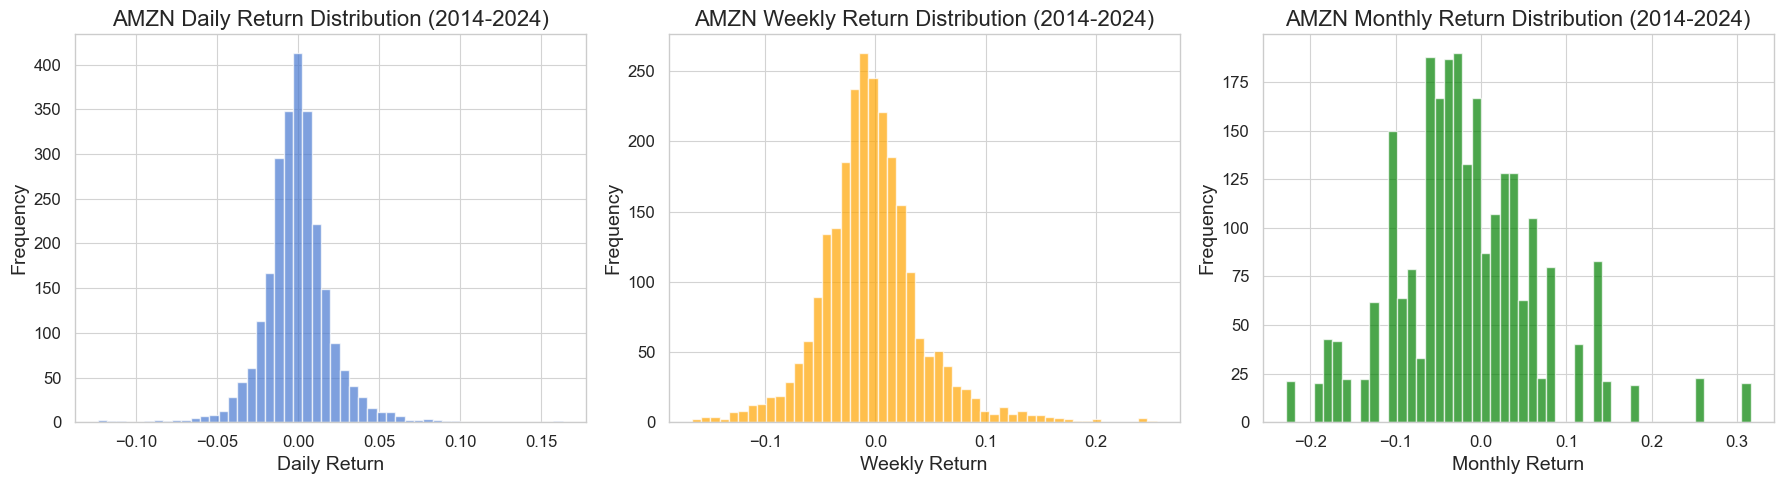

In [15]:
symbol_example = 'AMZN'
df_example = data[symbol_example]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df_example['daily_return'].hist(ax=axes[0], bins=50, alpha=0.7)
axes[0].set_title(f"{symbol_example} Daily Return Distribution ({start_year}-{end_year})")
axes[0].set_xlabel("Daily Return")
axes[0].set_ylabel("Frequency")

df_example['weekly_return'].hist(ax=axes[1], bins=50, alpha=0.7, color='orange')
axes[1].set_title(f"{symbol_example} Weekly Return Distribution ({start_year}-{end_year})")
axes[1].set_xlabel("Weekly Return")
axes[1].set_ylabel("Frequency")

df_example['monthly_return'].hist(ax=axes[2], bins=50, alpha=0.7, color='green')
axes[2].set_title(f"{symbol_example} Monthly Return Distribution ({start_year}-{end_year})")
axes[2].set_xlabel("Monthly Return")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

/var/folders/28/l2lfqs811tv1tcy8vm_ls2140000gn/T/ipykernel_5977/2170895780.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(daily_box_data, labels=[sym for sym in symbols if sym in data], vert=True)
/var/folders/28/l2lfqs811tv1tcy8vm_ls2140000gn/T/ipykernel_5977/2170895780.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(weekly_box_data, labels=[sym for sym in symbols if sym in data], vert=True)
/var/folders/28/l2lfqs811tv1tcy8vm_ls2140000gn/T/ipykernel_5977/2170895780.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(monthly_box_data, labels=[sym for sym in da

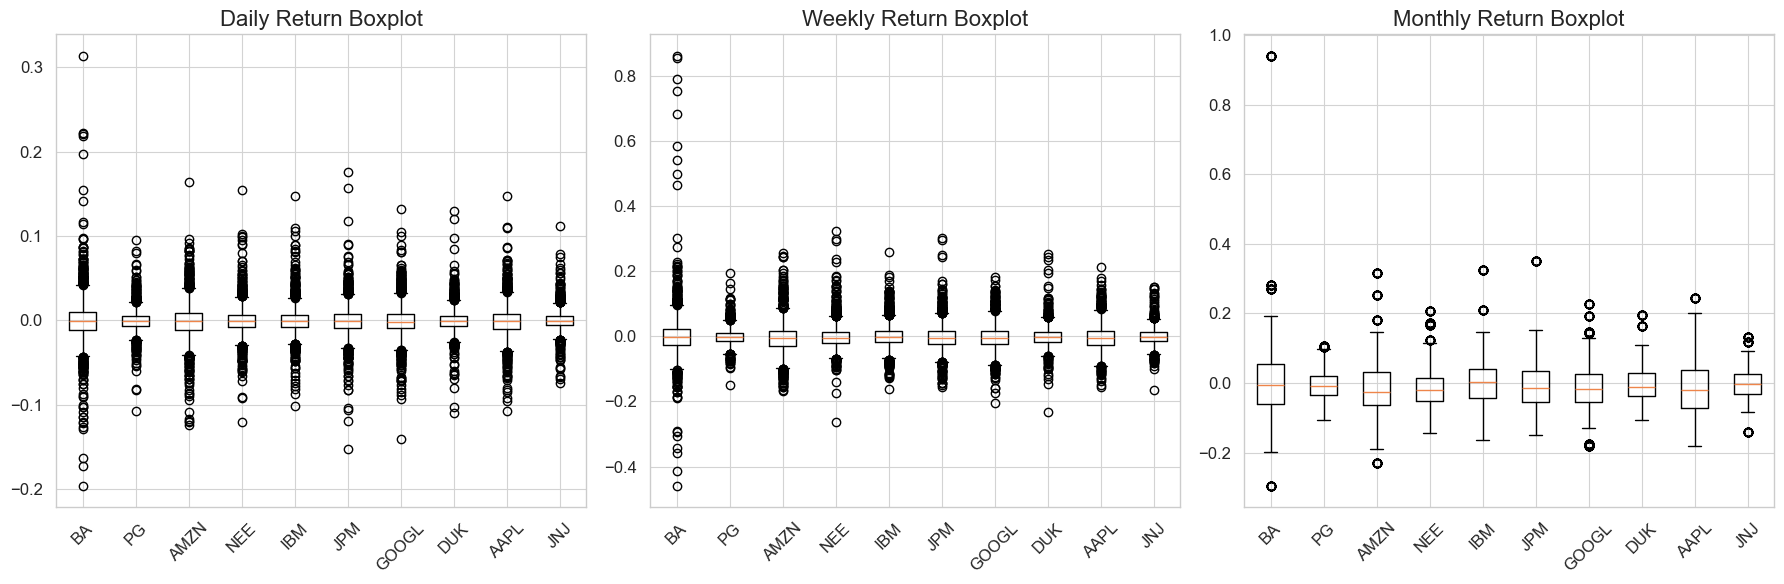

In [16]:
symbols = list(data.keys())
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Daily Return Boxplot
daily_box_data = [data[sym]['daily_return'].dropna() for sym in symbols if sym in data]
axes[0].boxplot(daily_box_data, labels=[sym for sym in symbols if sym in data], vert=True)
axes[0].set_title("Daily Return Boxplot")
axes[0].tick_params(axis='x', rotation=45)

# Weekly Return Boxplot
weekly_box_data = [data[sym]['weekly_return'].dropna() for sym in symbols if sym in data]
axes[1].boxplot(weekly_box_data, labels=[sym for sym in symbols if sym in data], vert=True)
axes[1].set_title("Weekly Return Boxplot")
axes[1].tick_params(axis='x', rotation=45)

# Monthly Return Boxplot
monthly_box_data = [data[sym]['monthly_return'].dropna() for sym in symbols if sym in data]
axes[2].boxplot(monthly_box_data, labels=[sym for sym in data], vert=True)
axes[2].set_title("Monthly Return Boxplot")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

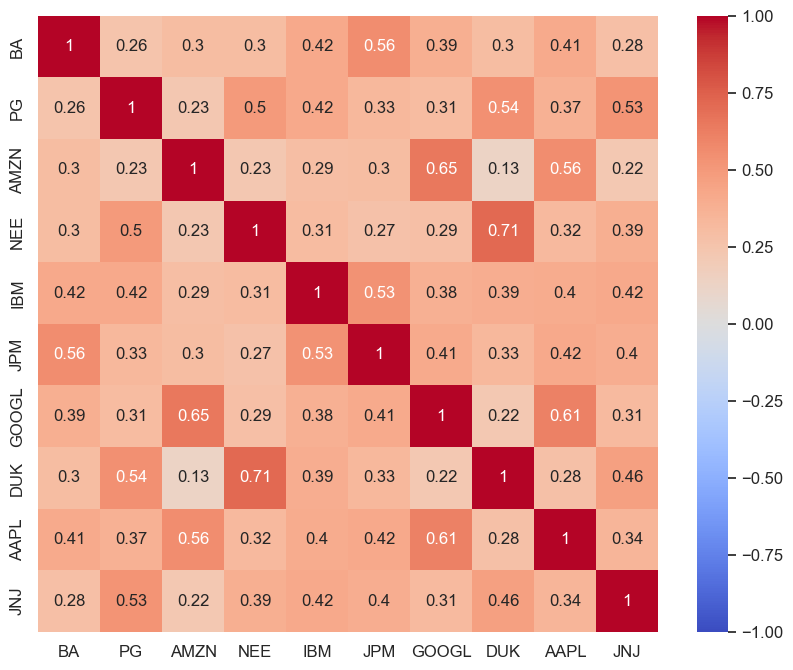

In [17]:
daily_returns_combined = pd.DataFrame()

for symbol, df in data.items():
    daily_returns_combined[symbol] = df['daily_return']

daily_returns_combined.dropna(how='all', inplace=True)

corr_matrix = daily_returns_combined.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("Daily Returns Correlation")
plt.show()

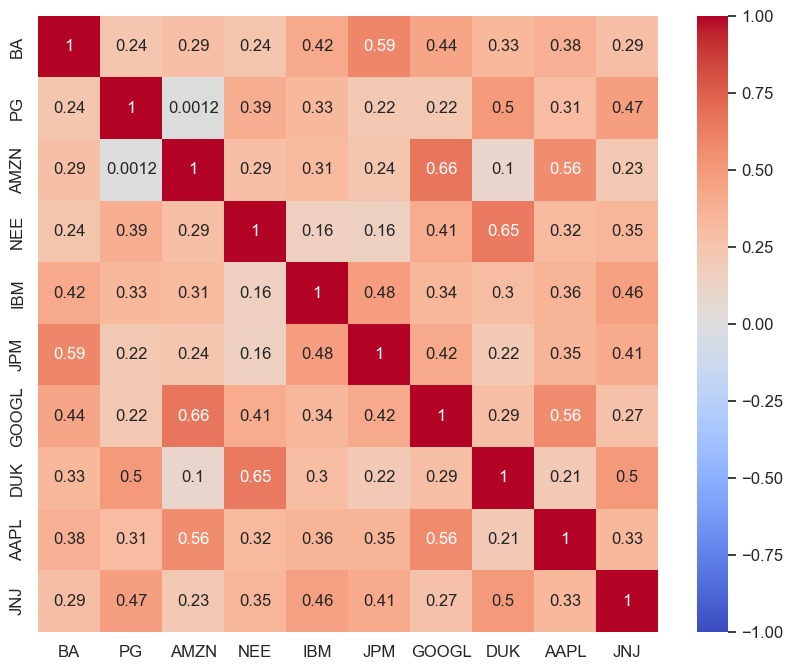

In [18]:
monthly_returns_combined = pd.DataFrame()

for symbol, df in data.items():
    monthly_returns_combined[symbol] = df['monthly_return']

# Drop rows that are all NaN
monthly_returns_combined.dropna(how='all', inplace=True)

# print("Daily Returns Correlation Matrix:")
corr_matrix = monthly_returns_combined.corr()
# display(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("Daily Returns Correlation")
plt.show()

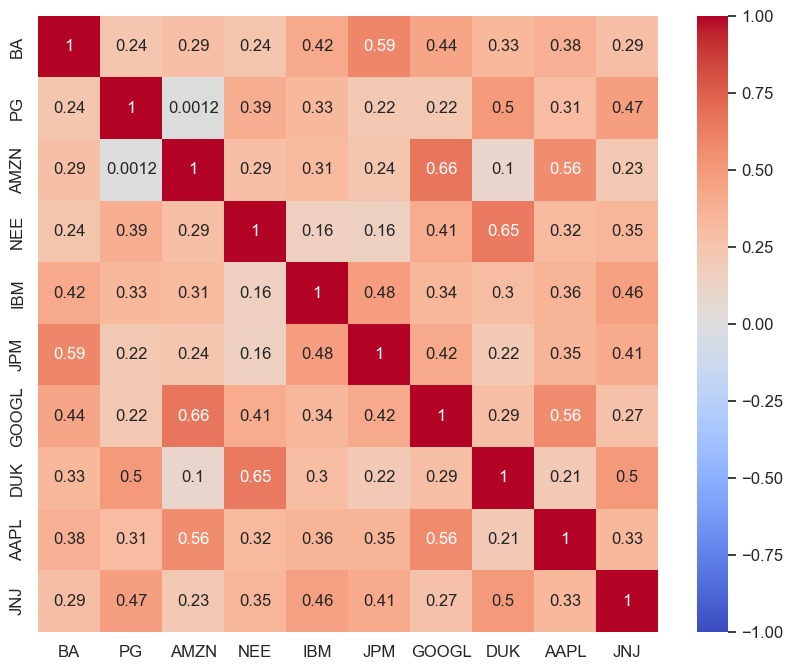

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("Daily Returns Correlation")
plt.show()

In [20]:
daily_results = compute.compute_returns_and_risk_for_stocks(data, return_type='daily_return', bins=50)
weekly_results = compute.compute_returns_and_risk_for_stocks(data, return_type='weekly_return', bins=50)
monthly_results = compute.compute_returns_and_risk_for_stocks(data, return_type='monthly_return', bins=50)

print("Daily Returns and Risk:")
for symbol, stats in daily_results.items():
    print(f"{symbol}: Expected Return = {stats['Expected Return']:.6f}, Risk = {stats['Risk']:.6f}")

print("\nWeekly Returns and Risk:")
for symbol, stats in weekly_results.items():
    print(f"{symbol}: Expected Return = {stats['Expected Return']:.6f}, Risk = {stats['Risk']:.6f}")

print("\nMonthly Returns and Risk:")
for symbol, stats in monthly_results.items():
    print(f"{symbol}: Expected Return = {stats['Expected Return']:.6f}, Risk = {stats['Risk']:.6f}")


Daily Returns and Risk:
BA: Expected Return = 0.000207, Risk = 0.025831
PG: Expected Return = -0.000198, Risk = 0.011768
AMZN: Expected Return = -0.000824, Risk = 0.020562
NEE: Expected Return = -0.000343, Risk = 0.015521
IBM: Expected Return = -0.000016, Risk = 0.014986
JPM: Expected Return = -0.000444, Risk = 0.017310
GOOGL: Expected Return = -0.000563, Risk = 0.017937
DUK: Expected Return = -0.000042, Risk = 0.013124
AAPL: Expected Return = -0.000685, Risk = 0.017992
JNJ: Expected Return = -0.000065, Risk = 0.011480

Weekly Returns and Risk:
BA: Expected Return = 0.001573, Risk = 0.066443
PG: Expected Return = -0.000989, Risk = 0.023717
AMZN: Expected Return = -0.004298, Risk = 0.045518
NEE: Expected Return = -0.001640, Risk = 0.034146
IBM: Expected Return = 0.000101, Risk = 0.032704
JPM: Expected Return = -0.002138, Risk = 0.036621
GOOGL: Expected Return = -0.003226, Risk = 0.037793
DUK: Expected Return = -0.000171, Risk = 0.028308
AAPL: Expected Return = -0.003656, Risk = 0.037629

# BARYCENTRIC AGGREGATION

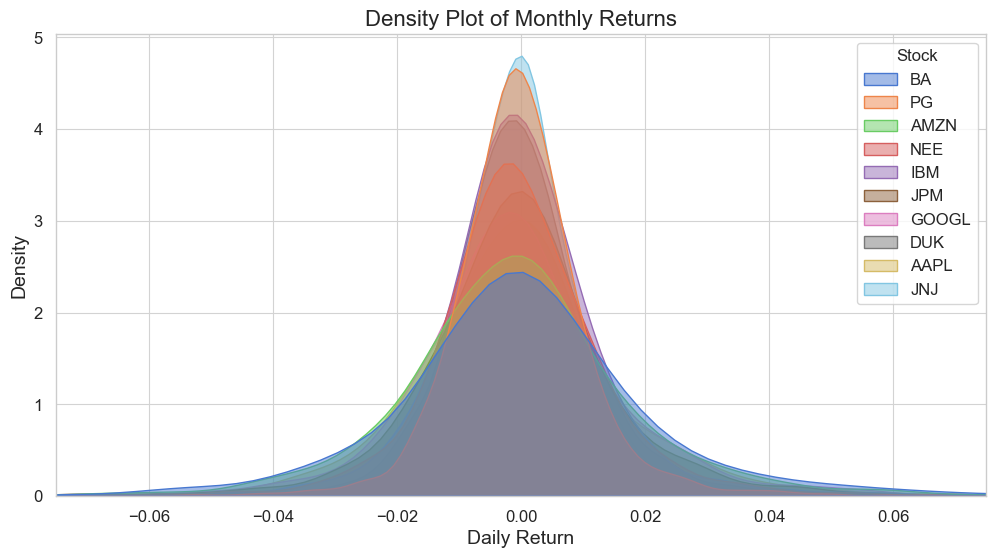

In [21]:
daily_returns = pd.DataFrame({symbol: df['daily_return'] for symbol, df in data.items()})
weekly_returns = pd.DataFrame({symbol: df['weekly_return'] for symbol, df in data.items()})
monthly_returns = pd.DataFrame({symbol: df['monthly_return'] for symbol, df in data.items()})

# melt the DataFrame for easier plotting
melted_daily_returns = daily_returns.melt(var_name='Stock', value_name='Daily Return')
melted_weekly_returns = weekly_returns.melt(var_name='Stock', value_name='Weekly Return')
melted_monthly_returns = monthly_returns.melt(var_name='Stock', value_name='Monthly Return')


# fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.figure(figsize=(12, 6))
sns.kdeplot(data=melted_daily_returns, x='Daily Return', hue='Stock', fill=True, alpha=0.5)
plt.title('Density Plot of Monthly Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.xlim(-0.075, 0.075)
plt.show()

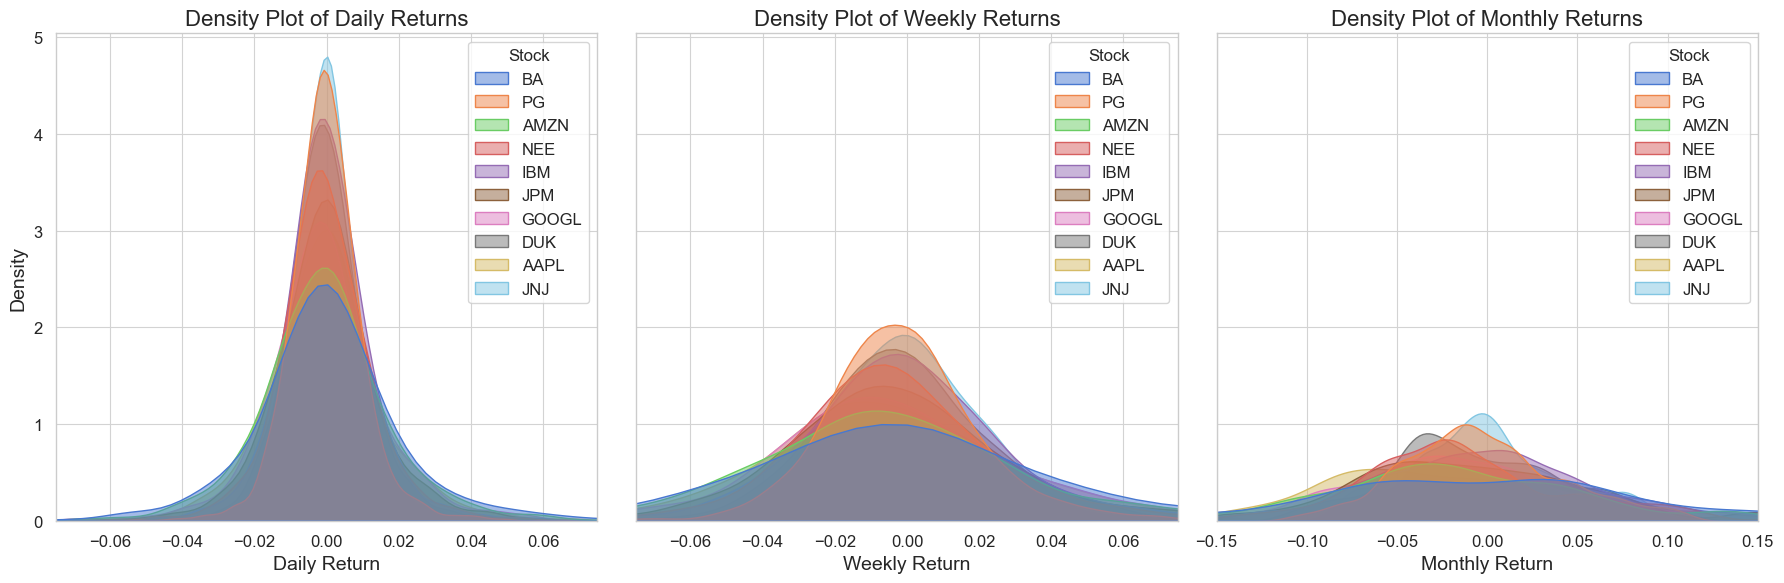

In [22]:
# Create subplots for daily, weekly, and monthly returns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot daily returns
sns.kdeplot(
    data=melted_daily_returns, 
    x='Daily Return', 
    hue='Stock', 
    fill=True, 
    alpha=0.5, 
    ax=axes[0]
)
axes[0].set_title('Density Plot of Daily Returns')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-0.075, 0.075)

# Plot weekly returns
sns.kdeplot(
    data=melted_weekly_returns, 
    x='Weekly Return', 
    hue='Stock', 
    fill=True, 
    alpha=0.5, 
    ax=axes[1]
)
axes[1].set_title('Density Plot of Weekly Returns')
axes[1].set_xlabel('Weekly Return')
axes[1].set_xlim(-0.075, 0.075)

# Plot monthly returns
sns.kdeplot(
    data=melted_monthly_returns, 
    x='Monthly Return', 
    hue='Stock', 
    fill=True, 
    alpha=0.5, 
    ax=axes[2]
)
axes[2].set_title('Density Plot of Monthly Returns')
axes[2].set_xlabel('Monthly Return')
axes[2].set_xlim(-0.15, 0.15)

# Adjust layout
plt.tight_layout()
plt.show()


In [23]:
daily_returns = pd.DataFrame({symbol: df['daily_return_norm'] for symbol, df in data.items()})
weekly_returns = pd.DataFrame({symbol: df['weekly_return_norm'] for symbol, df in data.items()})
monthly_returns = pd.DataFrame({symbol: df['monthly_return_norm'] for symbol, df in data.items()})

In [24]:
# melt the DataFrame for easier plotting
melted_daily_returns = daily_returns.melt(var_name='Stock', value_name='Daily Return')
melted_weekly_returns = weekly_returns.melt(var_name='Stock', value_name='Weekly Return')
melted_monthly_returns = monthly_returns.melt(var_name='Stock', value_name='Monthly Return')

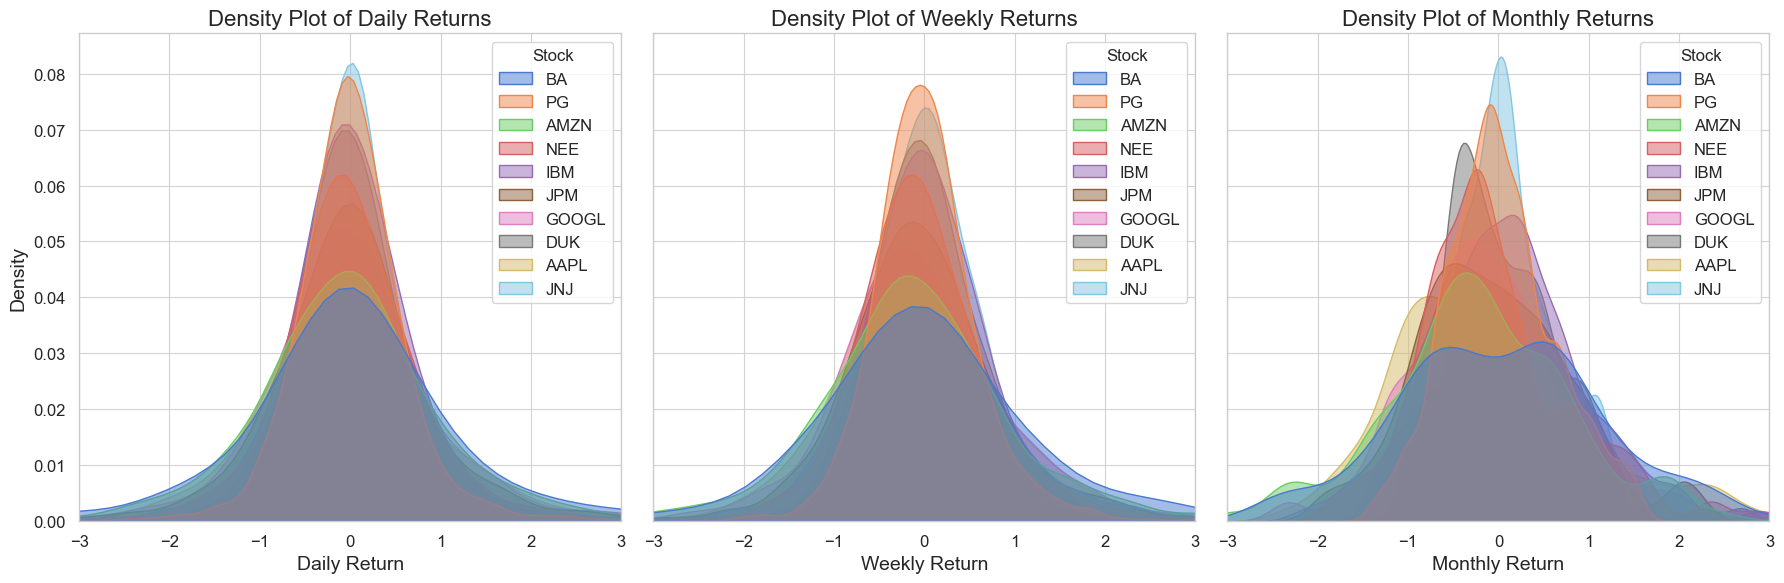

In [25]:
# Create subplots for daily, weekly, and monthly returns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot daily returns
sns.kdeplot(
    data=melted_daily_returns, 
    x='Daily Return', 
    hue='Stock', 
    fill=True, 
    alpha=0.5, 
    ax=axes[0]
)
axes[0].set_title('Density Plot of Daily Returns')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-3, 3)

# Plot weekly returns
sns.kdeplot(
    data=melted_weekly_returns, 
    x='Weekly Return', 
    hue='Stock', 
    fill=True, 
    alpha=0.5, 
    ax=axes[1]
)
axes[1].set_title('Density Plot of Weekly Returns')
axes[1].set_xlabel('Weekly Return')
axes[1].set_xlim(-3, 3)

# Plot monthly returns
sns.kdeplot(
    data=melted_monthly_returns, 
    x='Monthly Return', 
    hue='Stock', 
    fill=True, 
    alpha=0.5, 
    ax=axes[2]
)
axes[2].set_title('Density Plot of Monthly Returns')
axes[2].set_xlabel('Monthly Return')
axes[2].set_xlim(-3, 3)

# Adjust layout
plt.tight_layout()
plt.show()


In [26]:
for symbol, df in data.items():
    print(f"For {symbol} daily mean is {df['daily_return'].mean()} and normalized {df['daily_return_norm'].mean()}")

For BA daily mean is 0.00019462884810465513 and normalized 0.02875008971038016
For PG daily mean is -0.00019031276648997708 and normalized 0.006216432066374567
For AMZN daily mean is -0.0008612792979603963 and normalized -0.03306051159860682
For NEE daily mean is -0.00030790571835891486 and normalized -0.0006672074734893677
For IBM daily mean is 3.140617796497231e-05 and normalized 0.019195384193437717
For JPM daily mean is -0.00040801856021196293 and normalized -0.006527598812214003
For GOOGL daily mean is -0.0006331467464799028 and normalized -0.019706120653038693
For DUK daily mean is -3.120154076509805e-05 and normalized 0.015530462433234563
For AAPL daily mean is -0.0007193056375961409 and normalized -0.024749677602434662
For JNJ daily mean is -7.12226998479684e-05 and normalized 0.013187709498508716


## DAILY

Wasserstein distances from each stock to the barycenter:
PG: 0.28559839322132236
AMZN: 0.29917828316740436
NEE: 0.127585234003426
IBM: 0.1534019293145033
JPM: 0.1276328801007068
GOOGL: 0.1667874770796372
DUK: 0.22013162109788859
AAPL: 0.15963373873017986
JNJ: 0.2945232612029777
Expected return is -0.0348190523079765%
Expected risk is 1.605374081150674%


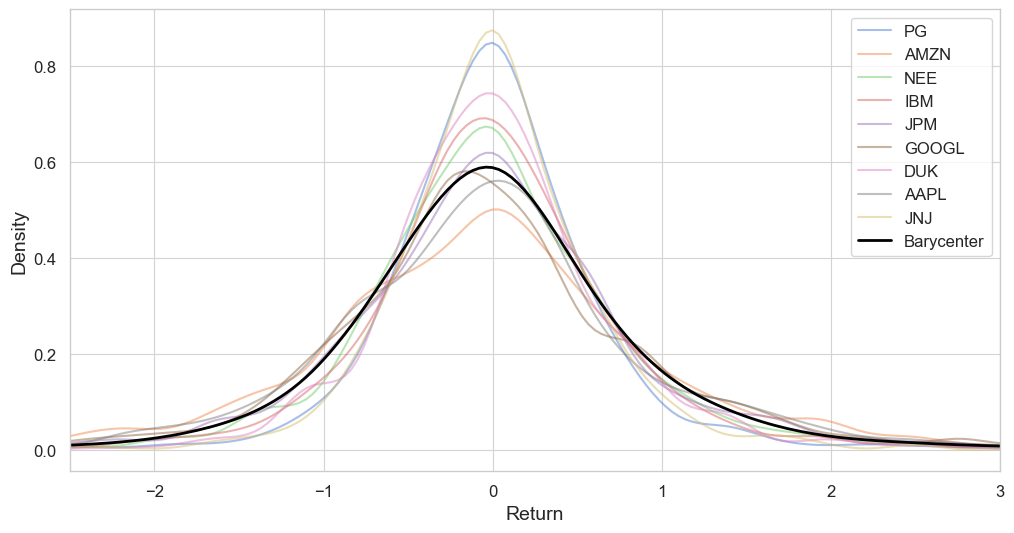

In [27]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='daily_return_norm',
    symbols=['AAPL', 'AMZN', 'DUK', 'GOOGL', 'JNJ', 'JPM', 'NEE', 'PG', 'IBM'],
    bins=70,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.075, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.48)

Wasserstein distances from each stock to the barycenter:
AMZN: 0.17638836558348409
IBM: 0.24567356363999782
GOOGL: 0.0928736008251124
AAPL: 0.08033895626205714
Expected return is -0.05349049515531966%
Expected risk is 1.823788029748174%


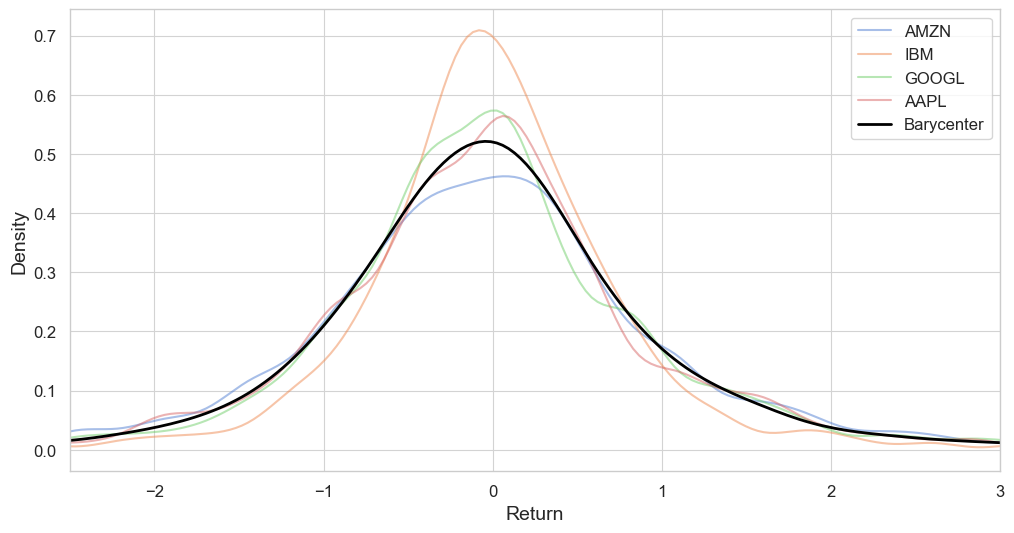

In [29]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='daily_return_norm',
    symbols=['AMZN', 'GOOGL', 'AAPL', 'IBM'],
    bins=70,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.075, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.48)

Wasserstein distances from each stock to the barycenter:
PG: 0.24945426507198956
AMZN: 0.3224983532646046
IBM: 0.1291771673994184
DUK: 0.18757793506375386
Expected return is -0.02537219415831817%
Expected risk is 1.5537394529459208%


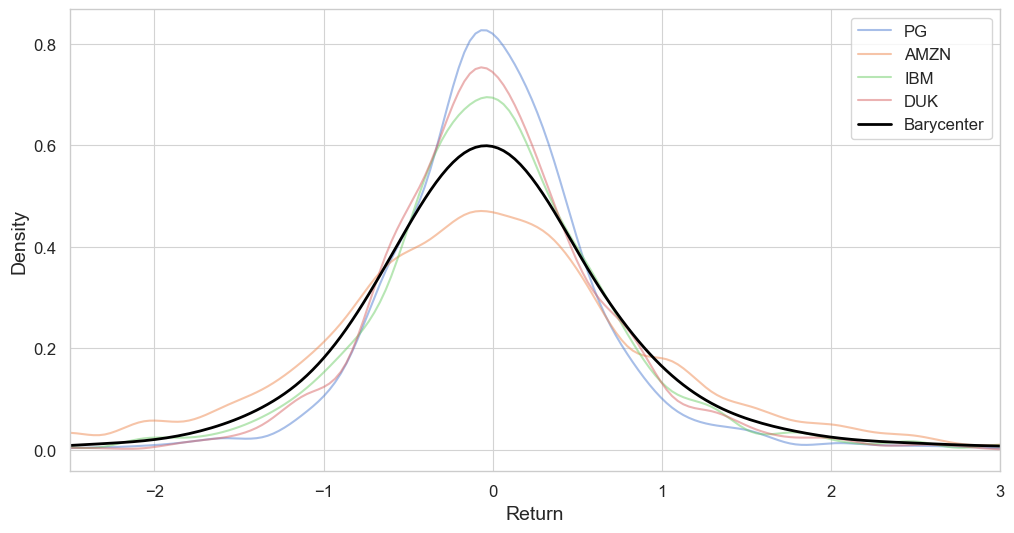

In [28]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='daily_return_norm',
    symbols=['AMZN', 'DUK', 'PG', 'IBM'],
    bins=70,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.075, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.48)

Wasserstein distances from each stock to the barycenter:
PG: 0.3146315580512853
AMZN: 0.4209749297695968
IBM: 0.10596919403276656
DUK: 0.2428215545527834
Expected return is -0.02854867704745954%
Expected risk is 1.6663392481924797%


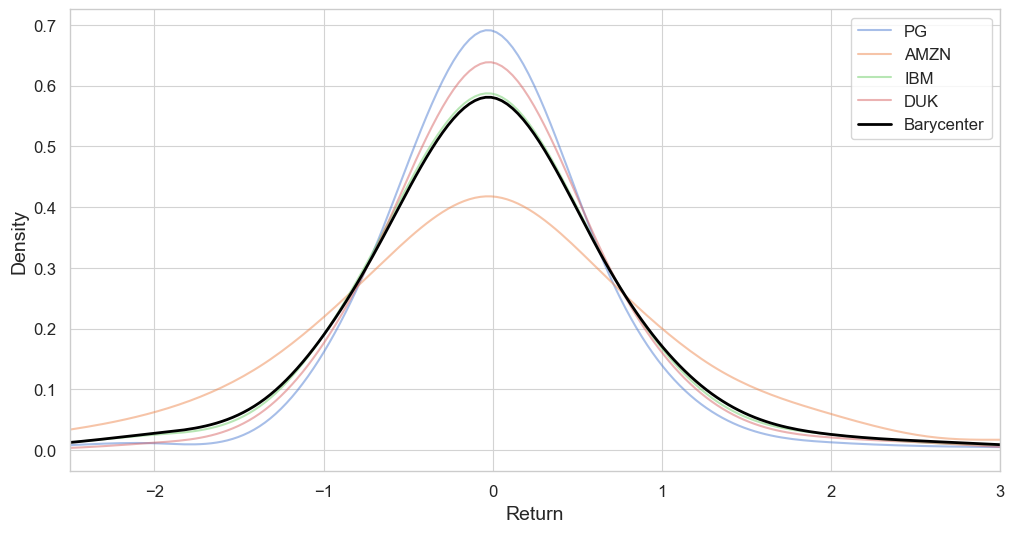

In [62]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2019-01-01',
    enddate='2024-12-31',
    period='daily_return_norm',
    symbols=['AMZN', 'DUK', 'PG', 'IBM'],
    bins=25,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.075, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.48)

## WEEKLY


Wasserstein distances from each stock to the barycenter:
PG: 0.2948118936500747
AMZN: 0.31922904599440494
NEE: 0.16555895933199535
IBM: 0.12331738567612607
JPM: 0.10893527018954416
GOOGL: 0.15743891538906235
DUK: 0.21571877042600604
AAPL: 0.1538118956746474
JNJ: 0.2924950491839427
Expected return is -0.04418530904567138%
Expected risk is 1.5274507443195646%


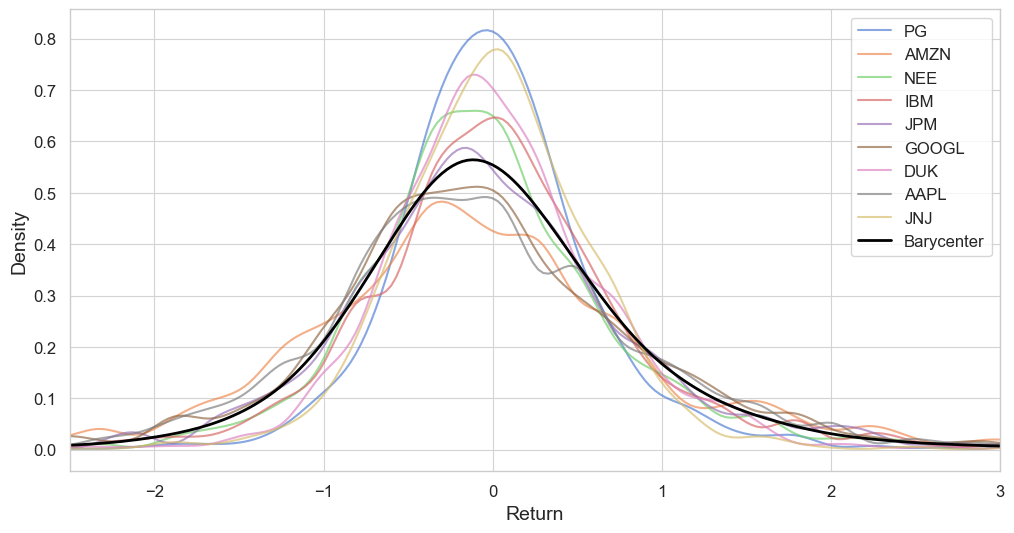

In [51]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='weekly_return_norm',
    symbols=['AAPL', 'AMZN', 'DUK', 'GOOGL', 'JNJ', 'JPM', 'NEE', 'PG', 'IBM'],
    bins=70,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.075, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.65)

Wasserstein distances from each stock to the barycenter:
PG: 0.14745015772174422
IBM: 0.14394053486564565
DUK: 0.10139345330705582
JNJ: 0.14567986885256806
Expected return is 0.020097253015963937%
Expected risk is 1.2655423866777518%


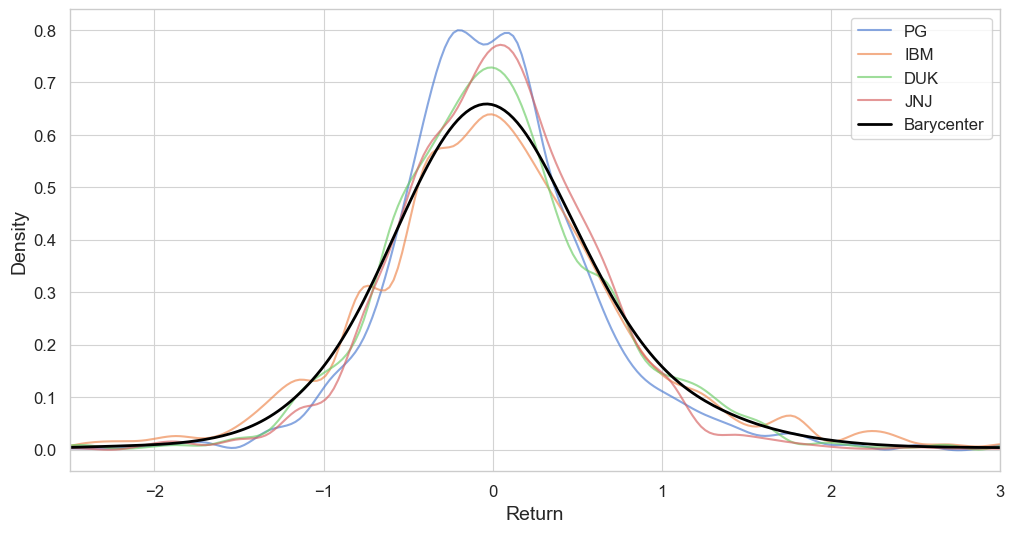

In [64]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='weekly_return_norm',
    symbols=['DUK','JNJ', 'PG', 'IBM'],
    bins=70,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.075, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.65)

## MONTHLY

Wasserstein distances from each stock to the barycenter:
PG: 0.34670765102403
AMZN: 0.3208321411240289
NEE: 0.19132407303017504
IBM: 0.2360650449775161
JPM: 0.19550432724091912
GOOGL: 0.17126243354895596
DUK: 0.23041645305152847
AAPL: 0.2762021445849536
JNJ: 0.33601153161020564
Expected return is -0.06227673556550436%
Expected risk is 1.5263055792005946%


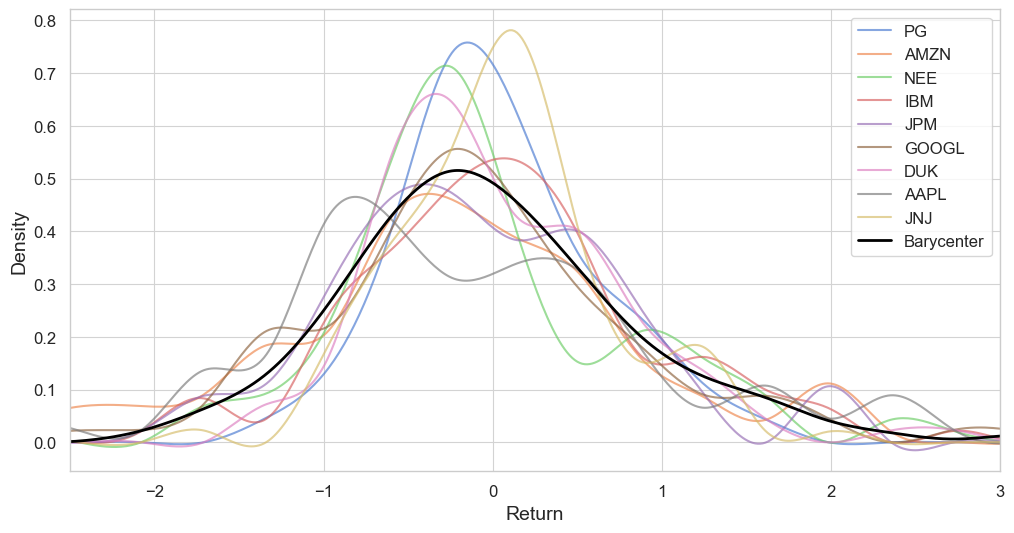

In [69]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='monthly_return_norm',
    symbols=['AAPL', 'AMZN', 'DUK', 'GOOGL', 'JNJ', 'JPM', 'NEE', 'PG', 'IBM'],
    bins=21,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.04, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.66)

Wasserstein distances from each stock to the barycenter:
AMZN: 0.23410824171615424
NEE: 0.25094231214319335
IBM: 0.24738581095540652
JPM: 0.19924977289599133
GOOGL: 0.1693397945331139
AAPL: 0.21136195489775847
Expected return is -0.11353704689044246%
Expected risk is 1.708547162383972%


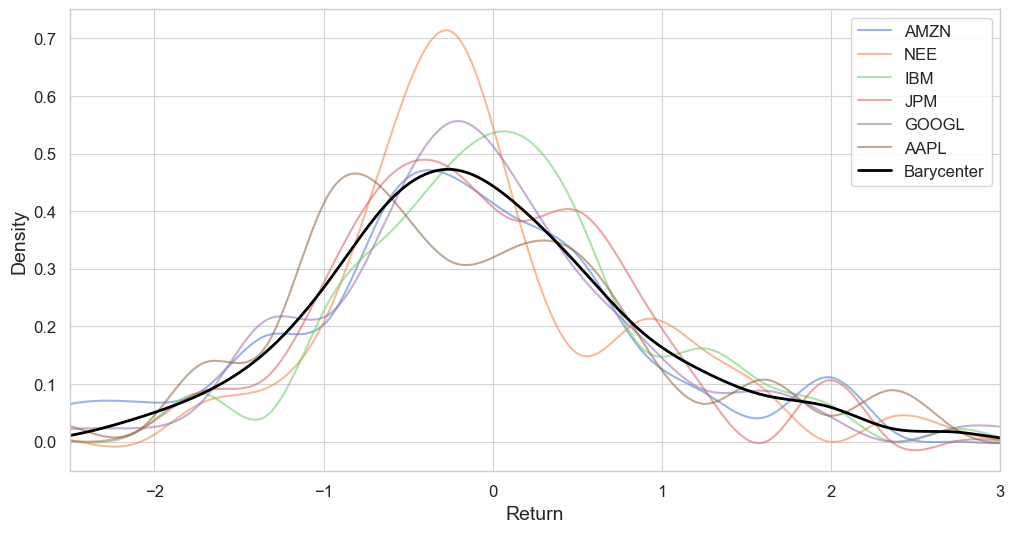

In [66]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='monthly_return_norm',
    symbols=['AAPL', 'AMZN', 'GOOGL', 'JPM', 'NEE', 'IBM'],
    bins=21,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.04, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-2.5, 3), alpha=0.55)

Wasserstein distances from each stock to the barycenter:
PG: 0.20788505215041914
IBM: 0.2529285064177753
DUK: 0.145861822125615
JNJ: 0.20094369805223328
Expected return is 0.06913460702291525%
Expected risk is 1.2822269872330034%
Probability of Positive Return: 0.3770


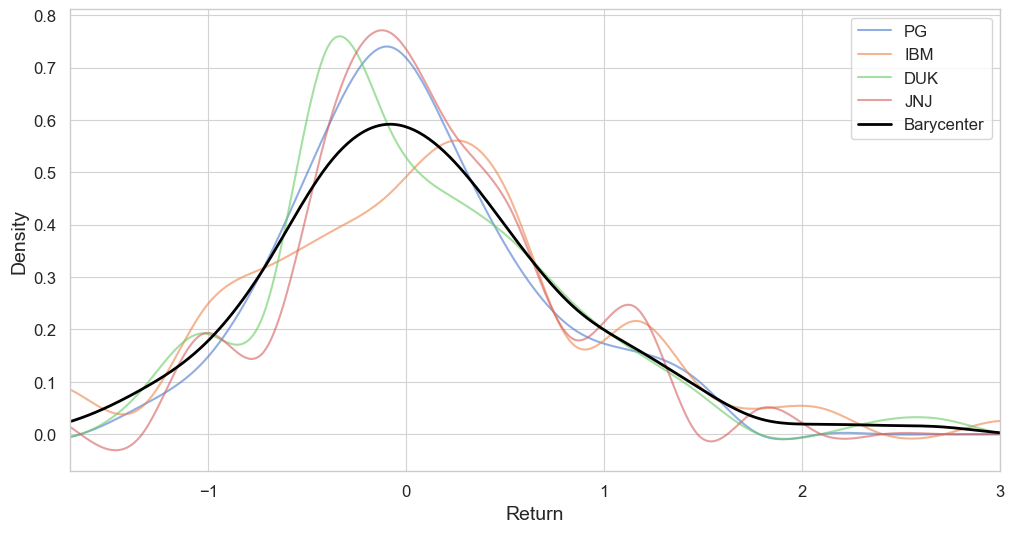

In [79]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='monthly_return_norm',
    symbols=['DUK', 'JNJ', 'PG', 'IBM'],
    bins=21,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# Example usage
prob = probability_positive_return(barycenter, bins)
print(f"Probability of Positive Return: {prob:.4f}")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.04, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-1.7, 3), alpha=0.6)

Wasserstein distances from each stock to the barycenter:
IBM: 0.21237117392409507
JPM: 0.1760835729749356
AAPL: 0.2238719274955872
Expected return is -0.029315587591296755%
Expected risk is 1.7275594247861816%


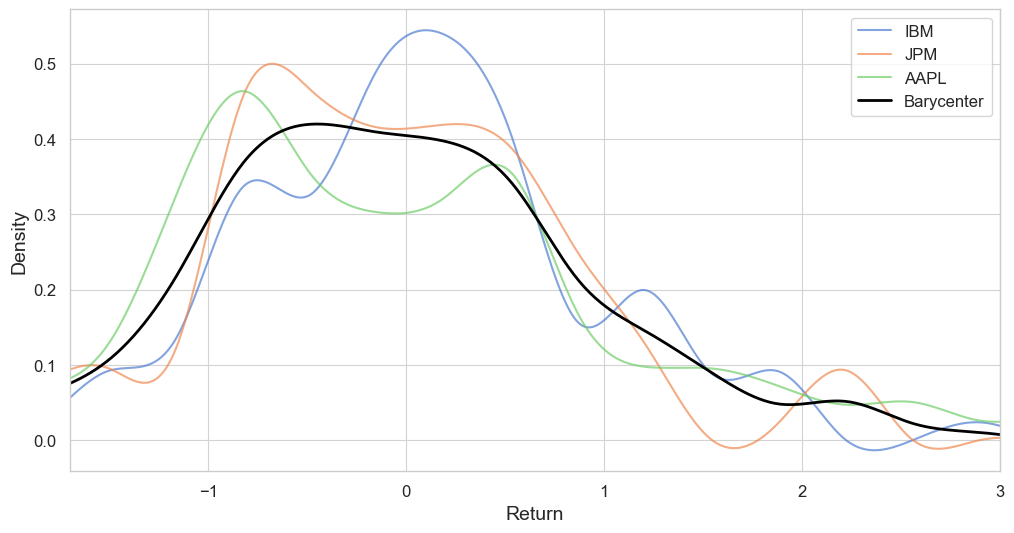

In [82]:
barycenter, histograms, bins = compute.compute_barycenter(
    stocks=data,
    startdate='2014-01-01',
    enddate='2024-12-31',
    period='monthly_return_norm',
    symbols=['AAPL', 'JPM', 'IBM'],
    bins=21,
    reg=0.1,
    numItermax=10_000
    )

distances = compute.compute_wasserstein_distances_pot(
    histograms=histograms,    # Normalized or raw histograms
    barycenter=barycenter,    # Normalized or raw barycenter
    bin_edges=bins            # Shared bin edges
)

print("Wasserstein distances from each stock to the barycenter:")
for symbol, distance in distances.items():
    print(f"{symbol}: {distance}")

ret_norm, risk_norm = compute.compute_expected_return_and_risk(barycenter, bins)
ret, risk = compute.denormalize_return_and_risk(ret_norm, risk_norm, scaler_daily)
print(f"Expected return is {ret * 100}%")
print(f"Expected risk is {risk*100}%")

# compute.visualize_barycenter_as_lines_raw(barycenter, histograms, bins, scaler_daily, (-0.04, 0.075), alpha=0.4)
# compute.visualize_barycenter_as_lines(barycenter, histograms, bins, (-2.5, 3), alpha=0.4)
compute.visualize_barycenter_as_smooth_lineplot(barycenter, histograms, bins, (-1.7, 3), alpha=0.68)

In [83]:
from scipy.integrate import simpson

def probability_positive_return(barycenter, bin_edges):
    """
    Compute the probability of positive return for the barycenter.

    Parameters:
        barycenter (ndarray): The barycenter density values.
        bin_edges (ndarray): The edges of the bins.

    Returns:
        prob_positive (float): Probability of positive return.
    """
    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Filter for positive returns
    positive_mask = bin_centers < 0
    positive_densities = barycenter[positive_mask]
    positive_bins = bin_centers[positive_mask]

    # Integrate the density over positive bins
    prob_positive = simpson(positive_densities, x=positive_bins)
    return prob_positive


In [84]:
# Example usage
prob = probability_positive_return(barycenter, bins)
print(f"Probability of Positive Return: {prob:.4f}")

Probability of Positive Return: 0.4714
